In [1]:
import sys
import torch
import torchvision

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from torchvision import transforms
from torch import nn
import heapq
from collections import Counter, defaultdict

In [56]:
from torchvision.datasets import CIFAR10, MNIST, FashionMNIST, MovingMNIST, CIFAR100, STL10, Imagenette

In [53]:
def get_dataset(tv_class, data_path ='./data', train=True, download=True, batch=100, shuffle=False):
  transform = transforms.Compose([
        transforms.ToTensor(),
    ])
  data_set = tv_class(root=data_path, download=download, transform=transform)
  return data_set, torch.utils.data.DataLoader(data_set, batch_size=batch, shuffle=shuffle)


In [5]:
def get_cifar10_dataset(data_path ='./data', download=True):
    """
    @param data_path : path where cifar data exists or to be downloaded; default : ./data
    @param download : if true downloads cifar10 data using torchvision; default: True
    @return train_dataset: 50000, test_dataset: 10000 as CIFAR10 Dataset; CIFAR10 Dataset can be
                  indexed or iterated to get data points.
                  Each data point is tuple(image:Tensor(3, 32, 32), label:int)
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_set = torchvision.datasets.CIFAR10(root=data_path, train=True, download=download, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root=data_path, train=False, download=download, transform=transform)

    return train_set, test_set
train_set, test_set = get_cifar10_dataset(download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=False)

100%|██████████| 170498071/170498071 [00:10<00:00, 15846198.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
{
    'cifar10': (0.0023838802083333338, 0.08365032438256635),
    'mnist': (0.8087977040816327, 0.8132775290501154),
    'fashion_mnist': (0.5020514030612245, 0.470456808547728),
    'cifar100': (0.00367412109375, 0.08827748788244753),
    'stl10': (0.03582523148148149, 0.1438556437556582),
    'imagenette': (0.017136831547595398, 0.17765259837512687)
}

In [57]:
# def process_train_loader(func):
data_mnist, mnist_loader = get_dataset(Imagenette)

100%|██████████| 1557161267/1557161267 [00:19<00:00, 81723755.20it/s]


Extracting ./data/imagenette2.tgz to ./data


In [60]:
num_data = len(data_mnist)
sparse_ori, sparse_delta = compare_sparsity(data_mnist)
x = np.array([i for i in range(100, num_data+100, 100)])
np.array(sparse_ori).mean(), np.array(sparse_delta).mean()

(0.017136831547595398, 0.17765259837512687)

In [6]:
def plot_histogram(data, title, num_bins=256, normalize=False, hist_color='blue'):
    """
    Utility function for plotting histogram.
    @param data: np.ndarray flattened
    @param title: string; plot title
    @param num_bins: int; number of histogram bins; default: 256
    @param normalize: bool; if true shows frequency density instead of actual frequency; default: False
    @param hist_color: string; color filled in bins; default: blue
    """
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=num_bins, color=hist_color, edgecolor='black', density=normalize)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency Density' if normalize else 'Frequency')
    plt.grid(True)
    plt.show()

In [16]:
def delta_sparcity(pixels):
    delta_values = np.diff(pixels)
    sparcity = {
        'zero_sparcity_before': 1 - np.count_nonzero(pixels)/len(pixels),
        'zero_sparcity_after': 1 - np.count_nonzero(delta_values)/len(delta_values)
    }
    return delta_values, sparcity

In [ ]:
all_pixels_cifar10 = np.array([])
for images, _ in train_loader:
    pixels = images.numpy().flatten()
    all_pixels_cifar10 = np.concatenate((all_pixels_cifar10, pixels))

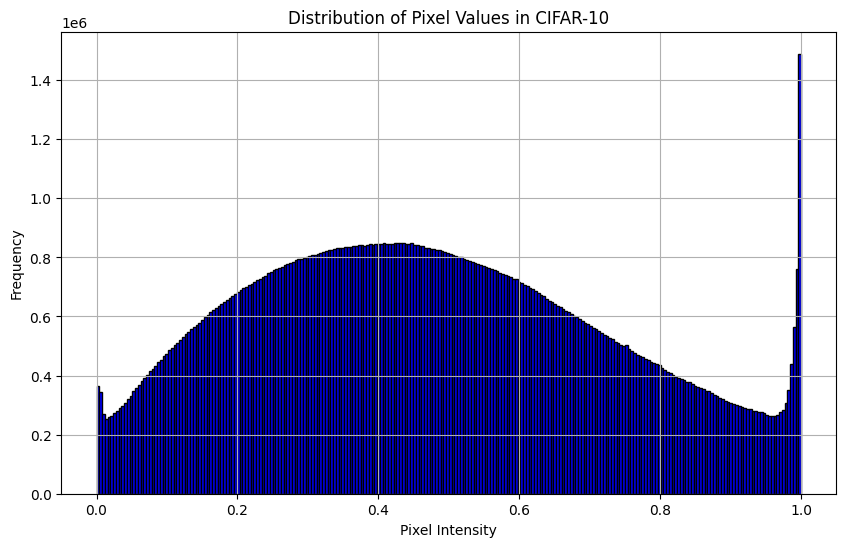

In [7]:
all_pixels = np.array([])
for images, _ in train_loader:
    pixels = images.numpy().flatten()
    all_pixels = np.concatenate((all_pixels, pixels))

plot_histogram(all_pixels, 'Distribution of Pixel Values in CIFAR-10')

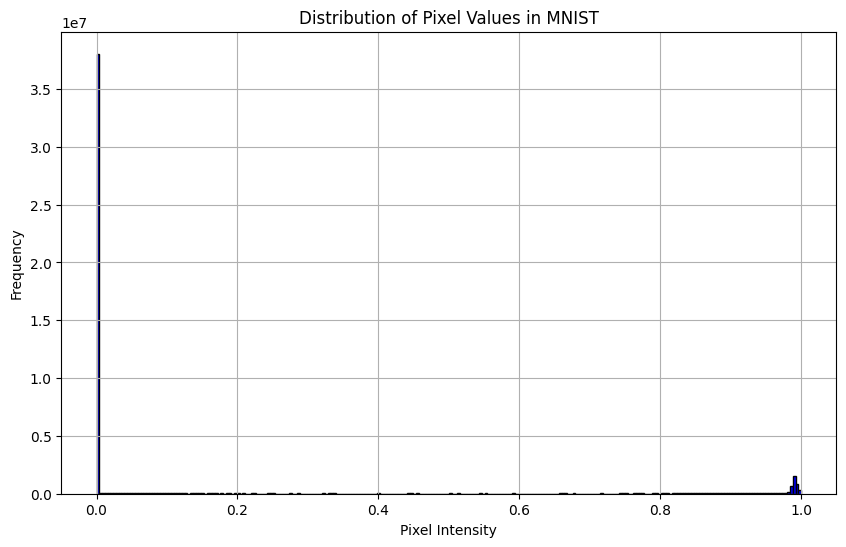

In [24]:
all_pixels = np.array([])
for images, _ in mnist_loader:
    pixels = images.numpy().flatten()
    all_pixels = np.concatenate((all_pixels, pixels))

plot_histogram(all_pixels, 'Distribution of Pixel Values in MNIST')

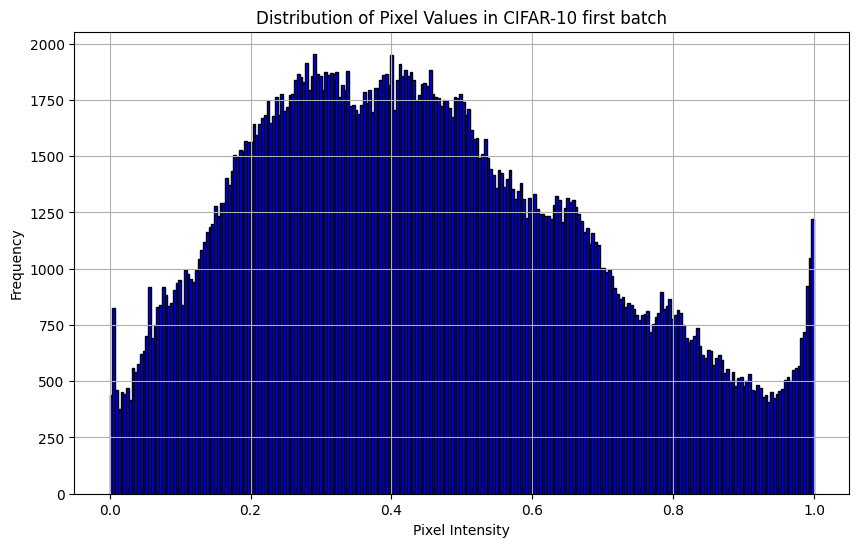

In [5]:
all_pixels = np.array([])
for images, _ in train_loader:
    pixels = images.numpy().flatten()
    all_pixels = np.concatenate((all_pixels, pixels))
    break

plot_histogram(all_pixels, 'Distribution of Pixel Values in CIFAR-10 first batch')

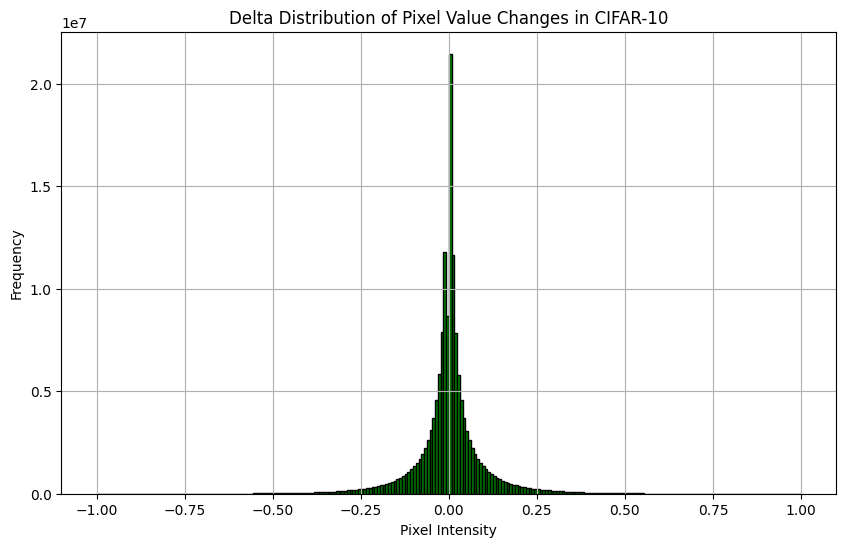

Sparcity level [0,1] {'zero_sparcity_before': 0.0023838802083333555, 'zero_sparcity_after': 0.08365006564876343}


In [11]:
d_pixels, sparcity = delta_sparcity(all_pixels)
plot_histogram(d_pixels, 'Delta Distribution of Pixel Value Changes in CIFAR-10', hist_color='green')
print("Sparcity level [0,1]", sparcity)

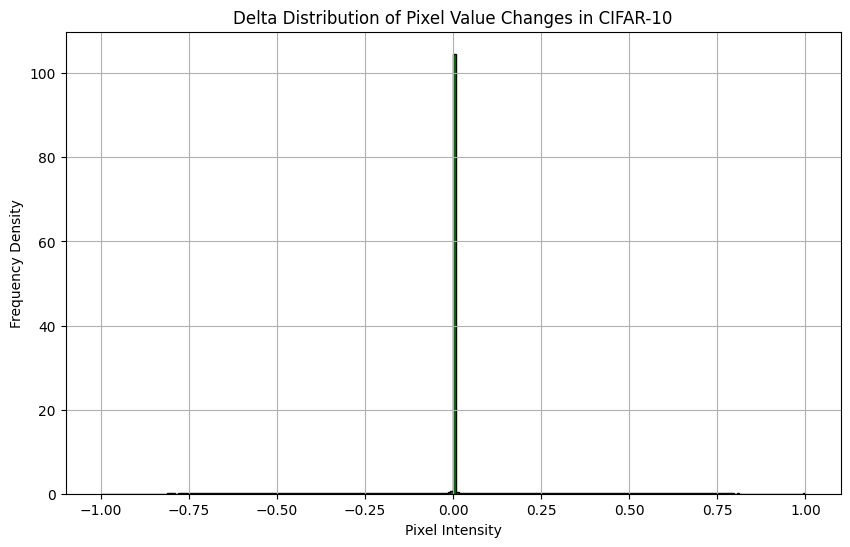

Sparcity level [0,1] (0.8087977040816327, 0.8132799067448959)


In [25]:
d_pixels, sparcity = delta_sparcity(all_pixels)
plot_histogram(d_pixels, 'Delta Distribution of Pixel Value Changes in CIFAR-10', normalize=True, hist_color='green')
print("Sparcity level [0,1]", sparcity)

In [ ]:
{
    'cifar10': (0.0023838802083333338, 0.08365032438256635),
    'mnist': (0.8087977040816327, 0.8132775290501154),
    'fashion_mnist': (0.5020514030612245, 0.470456808547728),
    'cifar100': (0.00367412109375, 0.08827748788244753)
}

In [28]:
def compare_sparsity(im_loader):
  sparse_ori = []
  sparse_delta = []

  for images, _ in im_loader:
      pixels = images.numpy().flatten()
      delta, sparsity = delta_sparcity(pixels)
      sparse_ori.append(sparsity['zero_sparcity_before'])
      sparse_delta.append(sparsity['zero_sparcity_after'])
  return sparse_ori, sparse_delta


In [42]:
num_data = len(data_mnist)
sparse_ori, sparse_delta = compare_sparsity(mnist_loader)
x = np.array([i for i in range(100, num_data+100, 100)])
np.array(sparse_ori).mean(), np.array(sparse_delta).mean()

(0.00367412109375, 0.08827748788244753)

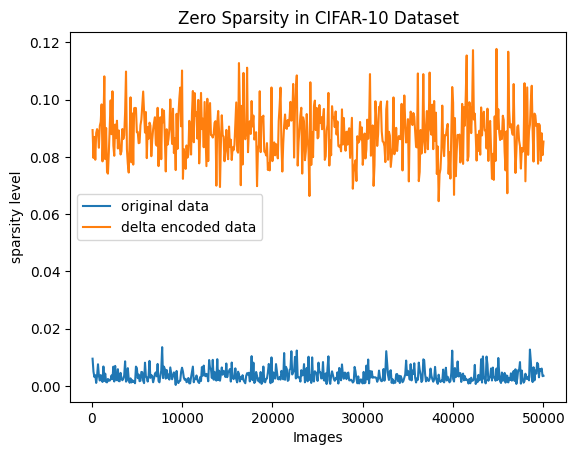

In [44]:
plt.plot(x, np.array(sparse_ori), label='original data')
plt.plot(x, np.array(sparse_delta), label='delta encoded data')
plt.legend()
plt.ylabel('sparsity level')
plt.xlabel('Images')
plt.title('Zero Sparsity in CIFAR-10 Dataset')
plt.show()

In [10]:
class Node:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    # For priority queue to compare nodes by frequency
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(char_freq):
    """Build the Huffman Tree based on character frequencies."""
    priority_queue = [Node(char, freq) for char, freq in char_freq.items()]
    heapq.heapify(priority_queue)

    while len(priority_queue) > 1:
        left = heapq.heappop(priority_queue)
        right = heapq.heappop(priority_queue)

        merged = Node(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(priority_queue, merged)

    return priority_queue[0]  # Return the root node of the Huffman tree

def generate_codes(node, prefix="", code_map=None):
    """Generate Huffman codes for characters."""
    if code_map is None:
        code_map = {}

    if node.char is not None:
        code_map[node.char] = prefix
    else:
        generate_codes(node.left, prefix + "0", code_map)
        generate_codes(node.right, prefix + "1", code_map)

    return code_map

def huffman_encode(arr):
    """Encode a numpy array using Huffman coding."""
    # Step 1: Calculate frequency of each symbol
    freq = Counter(arr.flat)

    # Step 2: Build Huffman tree
    root = build_huffman_tree(freq)

    # Step 3: Generate Huffman codes
    codes = generate_codes(root)

    # Step 4: Encode the array
    encoded_output = ''.join(codes[val] for val in arr.flat)

    return encoded_output, codes, root

def huffman_decode(encoded_str, root):
    """Decode a Huffman encoded string."""
    decoded_output = []
    current = root
    for bit in encoded_str:
        if bit == '0':
            current = current.left
        else:
            current = current.right

        if current.char is not None:
            decoded_output.append(current.char)
            current = root

    return np.array(decoded_output)





In [12]:
arr = all_pixels
new_var = 8*arr.nbytes
print("arr bits", new_var)
encoded_str, codes, root = huffman_encode(arr)
# print("Encoded string:", encoded_str)
print("encoded size", len(encoded_str))
# print("Huffman Codes:", codes)

decoded_arr = huffman_decode(encoded_str, root)

print("Decoded Array Difference Mean", (decoded_arr - arr).mean()) #Expected to be 0 for no loss

arr bits 9830400000
encoded size 1221913295
Decoded Array Difference Mean 0.0


In [27]:
arr = d_pixels
new_var = 8*arr.nbytes
print("arr bits", new_var)
encoded_str, codes, root = huffman_encode(arr)
# print("Encoded string:", encoded_str)
print("encoded size", len(encoded_str))
# print("Huffman Codes:", codes)

decoded_arr = huffman_decode(encoded_str, root)

print("Decoded Array Difference Mean", (decoded_arr - arr).mean())

arr bits 9830399936
encoded size 1100093636
Decoded Array Difference Mean 0.0


In [28]:
((len(encoded_str)+sys.getsizeof(codes)*8)/(8*arr.nbytes))

0.1120273904591627

In [25]:
np.unique(d_pixels).shape

(2089,)

In [19]:
sys.getsizeof(codes)/1024

9.09375

In [23]:
arr.nbytes/(1024)

1200000.0

In [24]:
len(encoded_str)/(8*1024)

149159.3377685547

In [22]:
len(codes)

2089

In [26]:
2432301/len(all_pixels)

7.917646484375

In [16]:
 1 - 2432301/19660800

0.8762867736816407

In [18]:
1 - 2242947/19660736

0.885917444799625

In [ ]:
def window_distribution(images, kernel_size=3, padding=1):
    padded_images = torch.nn.functional.pad(images, (padding, padding, padding, padding), mode='reflect')

    batch, channels, padded_height, padded_width = padded_images.shape
    output_height = padded_height - (padded_height % kernel_size)
    output_width = padded_width - (padded_width % kernel_size)
    modified_images = torch.zeros((batch, channels, output_height, output_width))
    central_values = torch.zeros((batch, channels, padded_height//kernel_size, padded_width//kernel_size))

    for i in range(0, output_height, kernel_size):
        for j in range(0, output_width, kernel_size):
            window = padded_images[:, :, i:i+kernel_size, j:j+kernel_size]
            center_value = window[:, :, 1, 1].unsqueeze(2).unsqueeze(3)
            central_values[:, :, i//kernel_size, j//kernel_size] = center_value[:, :, 0, 0]
            modified_images[:, :, i:i+kernel_size, j:j+kernel_size] = window - center_value

    central_values_flat = central_values.view(batch, channels, -1)
    delta_encoded_central_values = central_values_flat[:, :, 1:] - central_values_flat[:, :, :-1]

    return modified_images, delta_encoded_central_values

torch.Size([10, 3, 33, 33])
torch.Size([10, 3, 120])


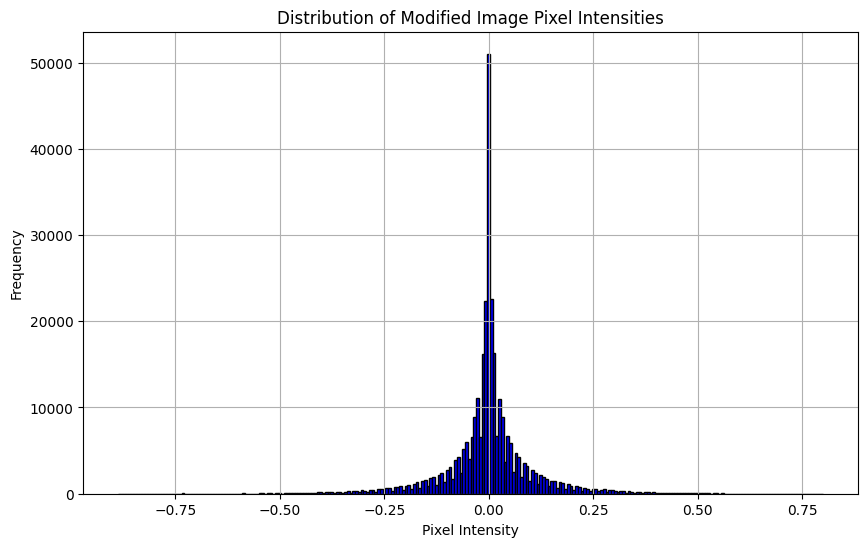

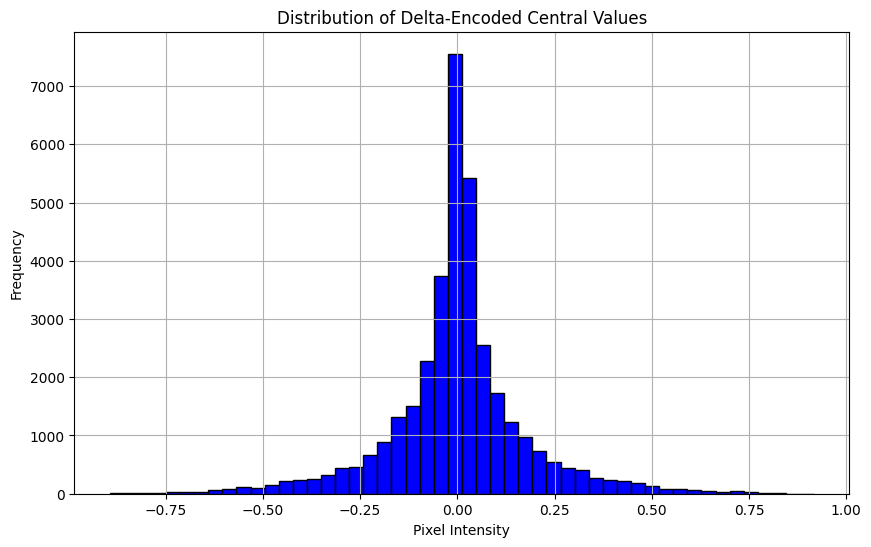

In [ ]:

images, _ = next(iter(train_loader))
modified_images, central_values_encoded = window_distribution(images)
modified_images_flat = modified_images.view(-1).numpy()
central_values_encoded_flat = central_values_encoded.view(-1).numpy()

plot_histogram(modified_images_flat, 'Distribution of Modified Image Pixel Intensities')
plot_histogram(central_values_encoded_flat, 'Distribution of Delta-Encoded Central Values', num_bins=50)  # Less bins for delta as values range is smaller

In [15]:
def run_length_encode(arr):
    """Encode a numpy array using run-length encoding."""
    edges = np.diff(arr) != 0
    changes = np.where(edges)[0] + 1
    indices = np.r_[0, changes]  # Include the start index

    # Compute run lengths and the corresponding values
    run_lengths = np.diff(np.r_[indices, arr.size])
    values = arr[indices]
    run_lengths.dtype = np.uint8

    return values, run_lengths

def run_length_decode(values, lengths):
    """Decode a run-length encoded sequence."""
    return np.repeat(values, lengths)


In [16]:
def size_compare(data, compressor, encoder, decoder):
  return {
      'orginal_size': sys.getsizeof(data),
      'encoded_size': sys.getsizeof(encoder(data)[0]) + sys.getsizeof(encoder(data)[1]),
      'encoded_compressed_size': sys.getsizeof(encoder(compressor(data))[0]) + sys.getsizeof(encoder(compressor(data))[1])
  }

In [36]:
size_compare(all_pixels, delta_distribution, run_length_encode ,run_length_decode)

{'orginal_size': 2457712,
 'encoded_size': 4592640,
 'encoded_compressed_size': 4685184}

In [42]:
run_length_encode(all_pixels)[1].nbytes

2296208

In [24]:
all_pixels.dtype

dtype('float64')

In [16]:
sys.getsizeof(all_pixels), sys.getsizeof(d_pixels), sys.get

(2457712, 2457704)

In [14]:
def encode(symbol_list, probabilities, data):
    """Encode the data using arithmetic coding based on provided probabilities."""
    low = 0.0
    high = 1.0
    for symbol in data:
        range_ = high - low
        high = low + range_ * probabilities[symbol][1]
        low = low + range_ * probabilities[symbol][0]
    return (low + high) / 2

def find_symbol_for_value(probabilities, value):
    """Given a value, find the symbol that it represents using the cumulative probabilities."""
    for symbol, (low, high) in probabilities.items():
        if low <= value < high:
            return symbol
    return None

def decode(symbol_list, probabilities, encoded_value, data_length):
    """Decode the data using the provided encoded value and probabilities."""
    current_value = encoded_value
    decoded_output = []
    for _ in range(data_length):
        symbol = find_symbol_for_value(probabilities, current_value)
        decoded_output.append(symbol)
        range_ = probabilities[symbol][1] - probabilities[symbol][0]
        current_value = (current_value - probabilities[symbol][0]) / range_
    return decoded_output
    
#simple test case 1
symbols = [0.1* k for k in range(11)]
probabilities = {0: (0.0, 0.7), 1: (0.7, 0.85), 0.1: (0.85, 1.0)}
data = [0, 0, 0.1, 0.1, 0, 0, 0, 1, 0, 0, 1, 0.1, 0, 0]
encoded_value = encode(symbols, probabilities, data)
decoded_output = decode(symbols, probabilities, encoded_value, len(data))

print(f"Encoded Value: {encoded_value}")
print(f"Decoded Output: {decoded_output}")


Encoded Value: 0.48185363479448445
Decoded Output: [0, 0, 0.1, 0.1, 0, 0, 0, 1, 0, 0, 1, 0.1, 0, 0]


In [ ]:
sys.getsizeof(data), sys.getsizeof(encoded_value), sys.getsizeof(decoded_output) #interesting same thing with different size could be datatype overhead

(168, 24, 184)

In [8]:
import torch
import torchvision.models as models

def load_pretrained_resnet(model_name='resnet18'):
    """
    Load a pre-trained ResNet model and return a dictionary of its weight tensors.

    @param model_name (str): Name of the ResNet model to load. Options include 'resnet18', 'resnet34', 'resnet50', etc.

    Returns dict: A dictionary where keys are tensor names and values are the weight tensors.
    """
    # Load the pre-trained model
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=True)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    else:
        raise ValueError(f"Unsupported ResNet model: {model_name}")

    # Dictionary to store name and tensor pairs
    weights = {}

    # Traverse all model parameters and tensors
    for name, param in model.named_parameters():
        weights[name] = param.data  # .data gives the tensor

    return weights


model_weights = load_pretrained_resnet('resnet50')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 54.0MB/s]


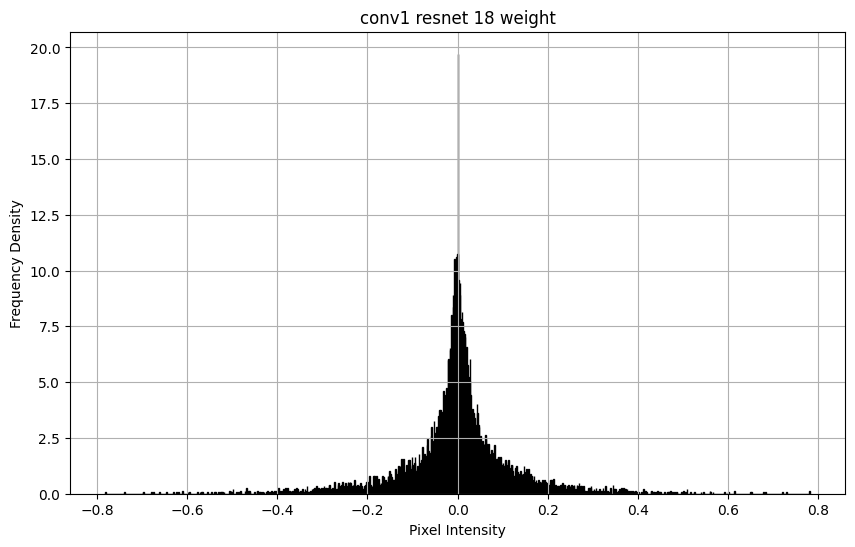

In [9]:
plot_histogram(np.array(model_weights['conv1.weight']).flatten(), 'conv1 resnet 18 weight',num_bins=1000, normalize=True)

In [10]:
w1 = np.array(model_weights['conv1.weight']).flatten()

In [12]:
w1[abs(w1)<1e-3].shape

(330,)

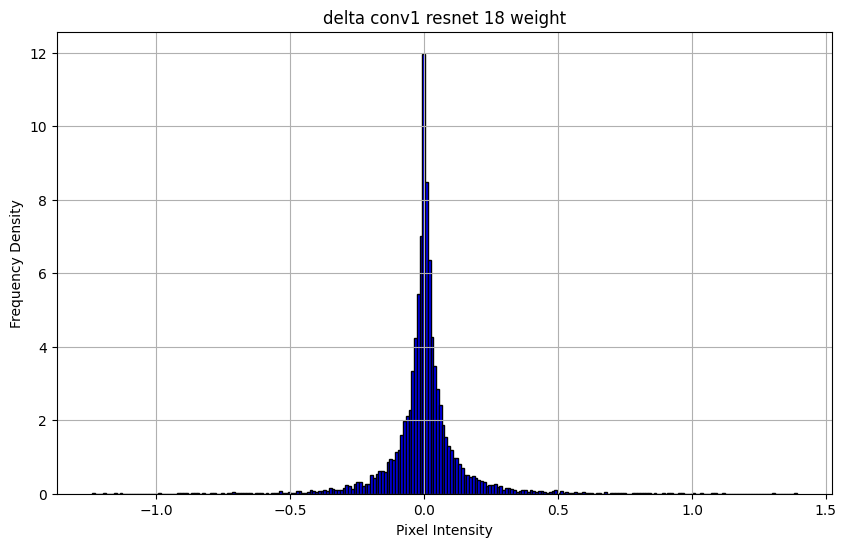

(0.0, 0.0)


In [18]:
d_weight, w_sparsity = delta_sparcity(model_weights['conv1.weight'].flatten())
plot_histogram(d_weight, 'delta conv1 resnet 18 weight', normalize=True)
print(w_sparsity)

In [19]:
np.count_nonzero(d_weight), d_weight.shape

(9407, (9407,))

In [20]:
np.unique(d_weight).shape

(9406,)